# Chapter 9: Predicting Continuous Target Variables with Regression Analysis

*Regression analysis* predict a continuous dependent variable.

## Introducing Linear Regression

### Simple Linear Regression

This is also called *univariate* regression because it models a single feature (called the *explanatory variable*) to predict a continuous *target* (*response varibale*). The relation is mapped as a line:
$$
    y = w_1x+b
$$
Where $b$, the bias variable, is the y-intercept, and $w_1$ is the weight coefficient.  This finds the best fit straight line through the training example. This line is called the *regresison line* with the *vertical offset* (or *residuals*) defined as 
$$
    | \hat{y} - y |
$$

### Multiple Linear Regression

*Multiple linear regression* is a generalization to higher dimensions:
$$
    y = \sum_{i = 1}^m w_ix_i + b = w^Tx + b
$$

This generalization uses the same evaluation and concepts as simple linear regression.

## Loading the Ames Housing Dataset


In [5]:
import pandas as pd
# columns = ['Overall Qual', 'Overall Cond', 'Gr Liv Area',
#            'Central Air', 'Total Bsmt SF', 'SalePrice']
# df = pd.read_csv('http://jse.amstat.org/v19n3/decock/AmesHousing.txt',
#                  sep='\t', usecols=columns)
# df.head()

In [6]:
# df.to_csv('ames_housing.txt')

In [7]:
df = pd.read_csv('ames_housing.txt').drop(columns = ['Unnamed: 0'])

In [8]:
df.shape

(2930, 6)

In [9]:
df['Central Air'] = df['Central Air'].map({'N': 0, 'Y': 1})

In [10]:
df.isnull().sum()

Overall Qual     0
Overall Cond     0
Total Bsmt SF    1
Central Air      0
Gr Liv Area      0
SalePrice        0
dtype: int64

In [11]:
df = df.dropna(axis=0)
df.isnull().sum()

Overall Qual     0
Overall Cond     0
Total Bsmt SF    0
Central Air      0
Gr Liv Area      0
SalePrice        0
dtype: int64

### Exploring the important characteristics of a dataset

*Exploratory Data Analysis*

*Create a scatterplot matrix*

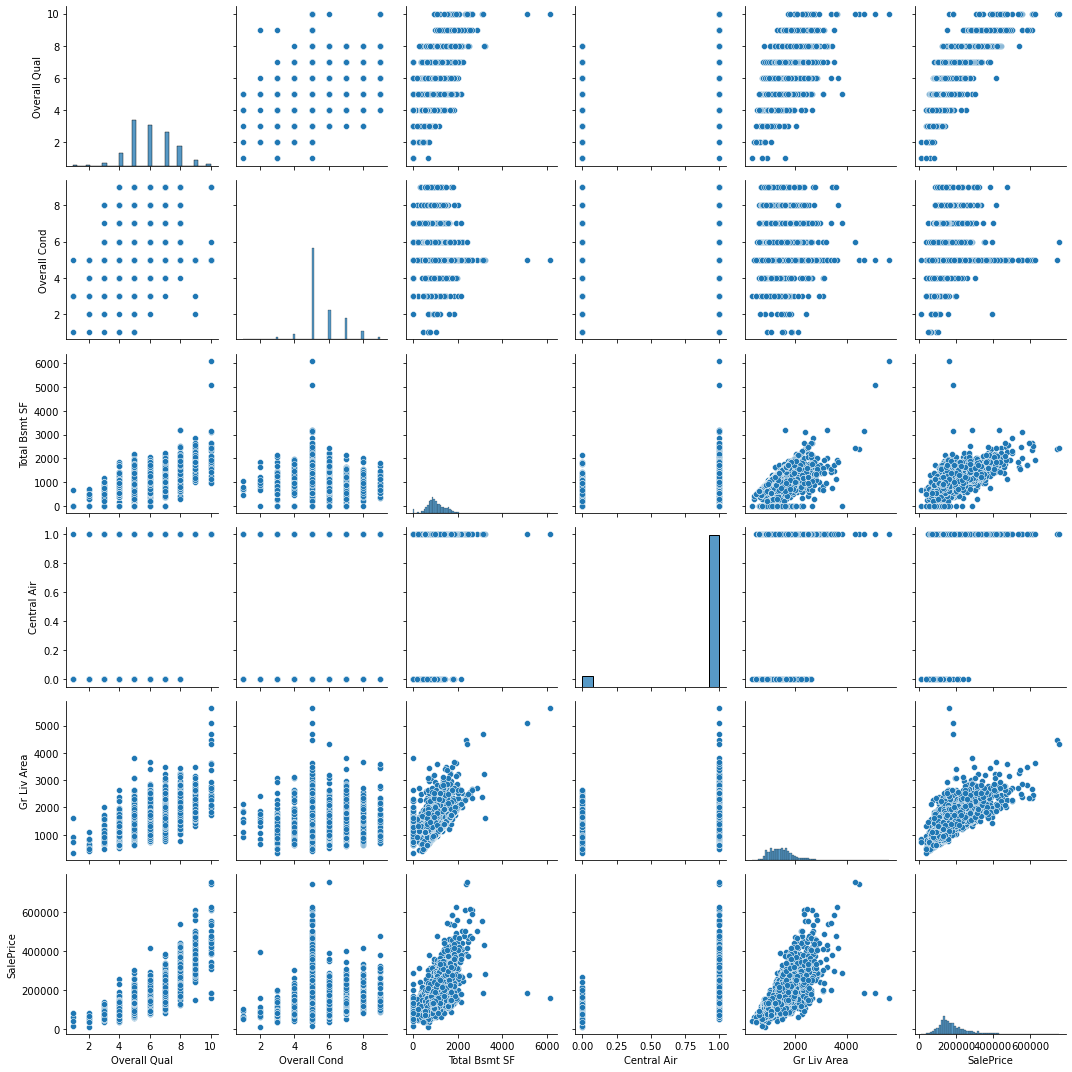

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.pairplot(df)
plt.tight_layout()
plt.show()

### Using a correlation matrix

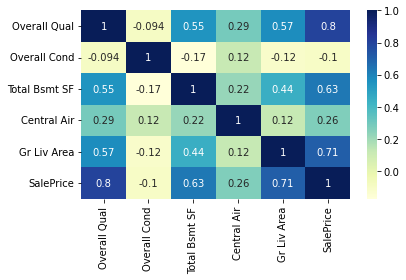

In [17]:
import numpy as np
dataplot = sns.heatmap(df.corr(), cmap="YlGnBu", annot=True)
plt.tight_layout()
plt.show()

## Implementing an ordinary least squares linear regression model

*Ordinary Least Squares (OLS)* calculates the line that minimizes the square errors of the regression line.

### Solving regression for regression parameters with gradient descent

Recall the implementation of Adaline, where a Loss function ($L(w, b)$) is minimized and then passed to a threshold function.  Ordinary least squares can be thought of as Adaline without the threshold function. 

In [24]:
class LinearRegressionGD:
    # implement a linear regression that uses gradient descent
    # to minimize the loss function
    
    def __init__(self, eta = 0.01, n_iter = 50, random_state = 1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
        
    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc = 0.0, scale = 0.01, size = X.shape[1])
        self.b_ = np.array([0.])
        self.losses_ = []
        
        for i in range(self.n_iter):
            output = self.net_input(X)
            error = (y - output)
            #get new weights
            self.w_ += self.eta * 2.0 * X.T.dot(error) / X.shape[0]
            self.b_ += self.eta * 2.0 * error.mean()
            # use square error
            loss = (error**2).mean()
            self.losses_.append(loss)
        return self
    
    def net_input(self, X):
        return np.dot(X, self.w_) + self.b_
    
    def predict(self, X):
        return self.net_input(X)

In [25]:
from sklearn.preprocessing import StandardScaler
X = df[['Gr Liv Area']].values
y = df['SalePrice'].values
sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten() 
lr = LinearRegressionGD(eta=0.1)
lr.fit(X_std, y_std)

It is clear how quickly the error minimizes.

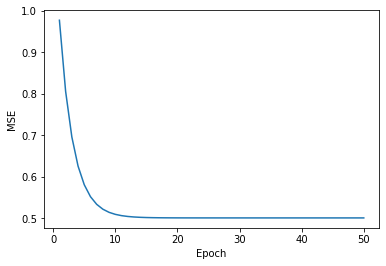

In [26]:
plt.plot(range(1, lr.n_iter+1), lr.losses_) 
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.show()

It is clear that house prices tend to increase as their size increases.

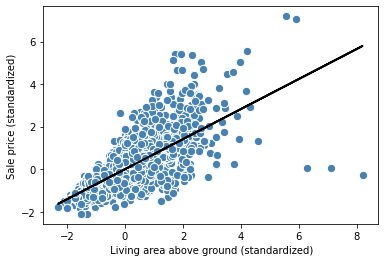

In [27]:
def lin_regplot(X, y, model):
    plt.scatter(X, y, c='steelblue', edgecolor='white', s=70)
    plt.plot(X, model.predict(X), color='black', lw=2)

lin_regplot(X_std, y_std, lr)
plt.xlabel(' Living area above ground (standardized)') 
plt.ylabel('Sale price (standardized)')
plt.show()

In [29]:
print(f'Slope: {lr.w_[0]:.3f}')
print(f'Intercept: {lr.b_[0]:.3f}')

Slope: 0.707
Intercept: -0.000


Predictions can be reverted to the original scale by the `inverse_transform` method of the `StandardScaler`.

In [33]:
feature_std = sc_x.transform(np.array([[2500]]))
target_std = lr.predict(feature_std)
target_reverted = sc_y.inverse_transform(target_std.reshape(-1, 1))
target_reverted.flatten()

array([292507.06743664])

## Fitting a robust regression model using RANSAC

*RAndom SAmple Consensus* (RANSAC) is a regression fitting model which fits the model to a subset of the data called *inliers*.  This makes the model less sensitive to outliers.

Algorithm summary:
1. Select a random number of samples to be inliers and fit the model with these.
2. Test the other data points with the fitted model and add the points that are within a user given tolerance to the inliers
3. Refit the model with all inliers
4. Estimate error of fitted model vs inliers
5. Terminate iteration after $n$ steps or when a predetermined performance is met

Implemented in scikit-learn:

In [37]:
from sklearn.linear_model import RANSACRegressor, LinearRegression
ransac = RANSACRegressor(
    LinearRegression(),
    max_trials=100, # default value, number of iterations
    min_samples=0.95, #min number of random samples
    residual_threshold=None, # default value ... 
    random_state=123)
ransac.fit(X, y)

RANSACRegressor(base_estimator=LinearRegression(), min_samples=0.95,
                random_state=123)

By default the residual threshold is determined by the *median absolute deviation* (MAD) of the target values. However, this is a use-case determined parameter.

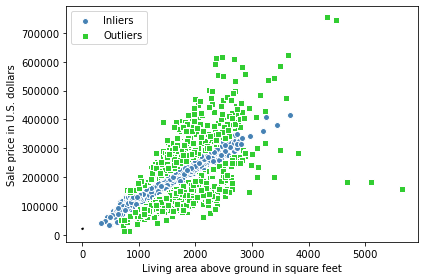

In [38]:
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis]) 
plt.scatter(X[inlier_mask], y[inlier_mask],
            c='steelblue', edgecolor='white',
            marker='o', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask],
            c='limegreen', edgecolor='white',
            marker='s', label='Outliers')
plt.plot(line_X, line_y_ransac, color='black', lw=2) 
plt.xlabel('Living area above ground in square feet') 
plt.ylabel('Sale price in U.S. dollars')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [40]:
print(f'Slope: {ransac.estimator_.coef_[0]:.3f}')
print(f'Intercept: {ransac.estimator_.intercept_:.3f}')

Slope: 106.348
Intercept: 20190.093


In [41]:
def mean_absolute_deviation(data):
    return np.mean(np.abs(data - np.mean(data))) 
mean_absolute_deviation(y)

58269.561754979375

If more of the outliers need to be captured, then the `residual_threshold` value can be increased greater than the MAD calculated above.

Note that RANSAC does not determine the effectiveness of the model on unseen data.